References

https://stackoverflow.com/questions/58182606/universal-sentence-encoder-reduce-vector-dimensionality

https://github.com/lmcinnes/umap

In [ ]:
import os
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import pandas as pd
import numpy as np

In [ ]:
pip install umap-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 9.3 MB/s eta 0:00:00


In [ ]:
pip install datashader


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 34.4 MB/s eta 0:00:00


In [ ]:
pip install bokeh

In [ ]:
pip install holoviews

In [ ]:
pip install scikit-image

In [ ]:
pip install colorcet

In [ ]:
import umap
import umap.plot

/usr/local/lib/python3.10/dist-packages/umap/plot.py:203: NumbaDeprecationWarning: The keyword argument 'nopython=False' was supplied. From Numba 0.59.0 the default is being changed to True and use of 'nopython=False' will raise a warning as the argument will have no effect. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit(nopython=False)


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
#Data Split - Random Seed = 42 is important.
#USE embeddings are saved according to the data generated by the seed.

train_data = pd.read_csv('gdrive/My Drive/train_2024.csv', quoting=3)
eval_data = pd.read_csv('gdrive/My Drive/test_2024.csv', quoting=3)
dev_data = pd.read_csv('gdrive/My Drive/dev_2024.csv', quoting=3)


train_texts = train_data['text'].tolist()
dev_texts = dev_data['text'].tolist()
eval_texts = eval_data['text'].tolist()

train_labels = train_data['label'].tolist()
dev_labels = dev_data['label'].tolist()
eval_labels = eval_data['label'].tolist()

train_texts.extend(dev_texts)
train_labels.extend(dev_labels)

X = train_texts
y = train_labels

train_texts, val_texts, train_labels, val_labels = train_test_split(X, y, test_size=0.1, random_state=42)
len(train_texts), len(train_labels), len(eval_texts), len(eval_labels)

(99000, 99000, 12001, 12001)

In [ ]:
type(train_labels)

numpy.ndarray

In [ ]:
train_labels = np.array(train_labels)
val_labels = np.array(val_labels)
eval_labels = np.array(eval_labels)

In [ ]:
train_embeddings = np.genfromtxt('gdrive/My Drive/USE_train.csv', delimiter=',')

In [ ]:
val_embeddings = np.genfromtxt('gdrive/My Drive/USE_val.csv', delimiter=',')

In [ ]:
eval_embeddings = np.genfromtxt('gdrive/My Drive/USE_eval.csv', delimiter=',')

In [ ]:
type(train_embeddings)

numpy.ndarray

<Axes: >

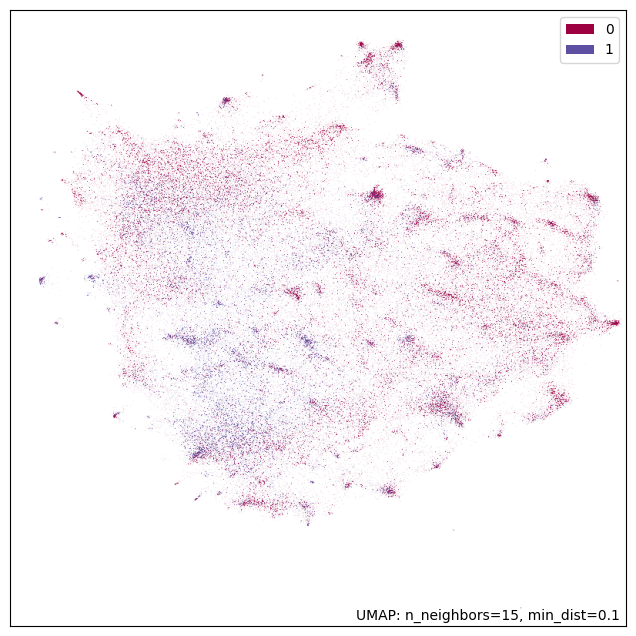

In [ ]:
mapper = umap.UMAP().fit(train_embeddings)
umap.plot.points(mapper, labels=train_labels)

In [ ]:
dense_map = umap.UMAP(densmap=True)

In [ ]:
new_train_embeddings = dense_map.fit_transform(train_embeddings)

In [ ]:
new_train_embeddings.shape

(99000, 2)

In [ ]:
new_val_embeddings = dense_map.transform(val_embeddings)

In [ ]:
new_eval_embeddings = dense_map.transform(eval_embeddings)

In [ ]:
import numpy as np
from sklearn.decomposition import PCA

In [ ]:
pca = PCA(n_components=256)

In [ ]:
new_training_embeddings = pca.fit_transform(train_embeddings)

In [ ]:
new_training_embeddings.shape

(99000, 256)

In [ ]:
new_val_embeddings = pca.transform(val_embeddings)

In [ ]:
new_val_embeddings.shape

(11000, 256)

In [ ]:
new_eval_embeddings = pca.transform(eval_embeddings)
new_eval_embeddings.shape

(12001, 256)

In [ ]:
from sklearn import svm

In [ ]:
svm_model = svm.SVC(kernel='linear', C = 0.01)

In [ ]:
svm_model.fit(new_training_embeddings, train_labels)

SVC(C=0.01, kernel='linear')

In [ ]:
from sklearn.metrics import accuracy_score, f1_score

In [ ]:
val_labels = np.array(val_labels)
#accuracy = svm_model.score(new_val_embeddings, val_labels)
val_preds = svm_model.predict(new_val_embeddings)
acc = accuracy_score(val_labels, val_preds)
f1 = f1_score(val_labels, val_preds)

In [ ]:
print(acc, f1)

0.8501818181818181 0.7879567678847142


In [ ]:
eval_preds = svm_model.predict(new_eval_embeddings)

In [ ]:
fei_op = pd.read_csv('gdrive/My Drive/submission-stack.csv')
count_matches = 0
for i in range(len(eval_preds)):
  if fei_op['label'][i] == eval_preds[i]:
    count_matches += 1


print(count_matches)
print(count_matches/len(eval_preds))

10110
0.8424297975168736


In [ ]:
import pickle

In [ ]:
with open('USE_pca_svm_.pkl','wb') as f:
    pickle.dump(svm_model, f)

In [ ]:
# load svm model
#with open('USE_pca_svm_.pkl', 'rb') as f:
#    clf2 = pickle.load(f)

Trying out a simple MLP

In [ ]:
import tensorflow as tf

In [ ]:
# Define the model architecture
def create_mlp(input_shape):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(256, activation='relu', input_shape=input_shape),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(2, activation='softmax')  # Output layer with softmax activation for binary classification
    ])
    return model

# Create the model
input_shape = (512,)
model = create_mlp(input_shape)

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Display the model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 256)               131328    
                                                                 
 dense_5 (Dense)             (None, 128)               32896     
                                                                 
 dense_6 (Dense)             (None, 64)                8256      
                                                                 
 dense_7 (Dense)             (None, 2)                 130       
                                                                 
Total params: 172610 (674.26 KB)
Trainable params: 172610 (674.26 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
history = model.fit(train_embeddings, train_labels, epochs=5, batch_size=32, validation_data=(val_embeddings, val_labels))

Epoch 1/5
3094/3094 [==============================] - 17s 5ms/step - loss: 0.3253 - accuracy: 0.8605 - val_loss: 0.3047 - val_accuracy: 0.8695
Epoch 2/5
3094/3094 [==============================] - 15s 5ms/step - loss: 0.2861 - accuracy: 0.8809 - val_loss: 0.3042 - val_accuracy: 0.8718
Epoch 3/5
3094/3094 [==============================] - 15s 5ms/step - loss: 0.2585 - accuracy: 0.8940 - val_loss: 0.3045 - val_accuracy: 0.8707
Epoch 4/5
3094/3094 [==============================] - 16s 5ms/step - loss: 0.2290 - accuracy: 0.9077 - val_loss: 0.3141 - val_accuracy: 0.8737
Epoch 5/5
3094/3094 [==============================] - 8s 3ms/step - loss: 0.1987 - accuracy: 0.9211 - val_loss: 0.3374 - val_accuracy: 0.8711


In [ ]:
# Evaluate the model
loss, accuracy = model.evaluate(val_embeddings, val_labels)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

344/344 [==============================] - 0s 1ms/step - loss: 0.3374 - accuracy: 0.8711
Test Loss: 0.3373930752277374
Test Accuracy: 0.8710908889770508


In [ ]:
val_pred = model.predict(val_embeddings)

344/344 [==============================] - 0s 1ms/step


In [ ]:
val_pred = np.argmax(val_pred, axis=1)

In [ ]:
f1_score(val_labels, val_pred)

0.8223502881483338

In [ ]:
eval_pred = model.predict(eval_embeddings)
eval_pred = np.argmax(eval_pred, axis=1)

376/376 [==============================] - 1s 2ms/step


In [ ]:
fei_op = pd.read_csv('gdrive/My Drive/submission-stack.csv')
count_matches = 0
for i in range(len(eval_pred)):
  if fei_op['label'][i] == eval_pred[i]:
    count_matches += 1


print(count_matches)
print(count_matches/len(eval_pred))

10314
0.8594283809682527


In [ ]:
model.save('gdrive/My Drive/USE_MLP.keras')

kNN on PCA(USE_Embeddings)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
pca2 = PCA(n_components=100)

In [ ]:
train_embeds_100 = pca2.fit_transform(train_embeddings)
val_embeds_100 = pca2.transform(val_embeddings)
eval_embeds_100 = pca2.transform(eval_embeddings)

In [ ]:
knn = KNeighborsClassifier(n_neighbors=100)

In [ ]:
knn.fit(train_embeds_100, train_labels)

KNeighborsClassifier(n_neighbors=100)

In [ ]:
val_pred = knn.predict(val_embeds_100)

In [ ]:
acc = accuracy_score(val_labels, val_pred)
f1 = f1_score(val_labels, val_pred)
print(acc, f1)

0.8345454545454546 0.7702020202020202


In [ ]:
eval_pred = knn.predict(eval_embeds_100)
fei_op = pd.read_csv('gdrive/My Drive/submission-stack.csv')
count_matches = 0
for i in range(len(eval_pred)):
  if fei_op['label'][i] == eval_pred[i]:
    count_matches += 1


print(count_matches)
print(count_matches/len(eval_pred))

9896
0.824597950170819


AdaBoost

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

In [ ]:
adaboost = AdaBoostClassifier(estimator = DecisionTreeClassifier(max_depth=2), n_estimators=100)

In [ ]:
adaboost.fit(train_embeds_100, train_labels)

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=2),
                   n_estimators=100)

In [ ]:
val_pred = adaboost.predict(val_embeds_100)
acc = accuracy_score(val_labels, val_pred)
f1 = f1_score(val_labels, val_pred)
print(acc, f1)

0.8323636363636364 0.7676411290322581


In [ ]:
eval_pred = adaboost.predict(eval_embeds_100)
fei_op = pd.read_csv('gdrive/My Drive/submission-stack.csv')
count_matches = 0
for i in range(len(eval_pred)):
  if fei_op['label'][i] == eval_pred[i]:
    count_matches += 1


print(count_matches)
print(count_matches/len(eval_pred))

9820
0.8182651445712857


RandomForest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
rf = RandomForestClassifier(max_depth=20, random_state=0, n_estimators=150)

In [ ]:
rf.fit(train_embeds_100, train_labels)

RandomForestClassifier(max_depth=20, n_estimators=150, random_state=0)

In [ ]:
train_pred = rf.predict(train_embeds_100)
acc = accuracy_score(train_labels, train_pred)
f1 = f1_score(train_labels, train_pred)
print(acc, f1)

0.9950707070707071 0.9932432432432432


In [ ]:
val_pred = rf.predict(val_embeds_100)
acc = accuracy_score(val_labels, val_pred)
f1 = f1_score(val_labels, val_pred)
print(acc, f1)

0.8295454545454546 0.7480177395511357


In [ ]:
eval_pred = rf.predict(eval_embeds_100)
fei_op = pd.read_csv('gdrive/My Drive/submission-stack.csv')
count_matches = 0
for i in range(len(eval_pred)):
  if fei_op['label'][i] == eval_pred[i]:
    count_matches += 1


print(count_matches)
print(count_matches/len(eval_pred))

9720
0.8099325056245313
